In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
data=pd.read_csv('heart_disease_uci.csv')
data.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
cat_cols = ['sex', 'cp', 'restecg', 'slope', 'thal', 'fbs', 'exang']

# convert boolean to string
data[['fbs', 'exang']] = data[['fbs', 'exang']].replace({0: 'FALSE', 1: 'TRUE'})

preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), cat_cols)
    ]
)

# binary target
data['num'] = (data['num'] > 0).astype(int)

X = preprocess.fit_transform(data.drop('num', axis=1))
y = data['num'].values


In [5]:
print(X)

[[ 1.00738556  0.70517639  0.30364317 ...  0.          1.
   0.        ]
 [ 1.43203377  1.51856943  0.78996695 ...  0.          0.
   1.        ]
 [ 1.43203377 -0.65047866  0.26693949 ...  1.          0.
   1.        ]
 ...
 [ 0.15808914 -0.54202626  0.21188397 ...  0.          1.
   0.        ]
 [ 0.4765753  -0.10821664  1.69838307 ...  0.          1.
   0.        ]
 [ 0.90122351 -0.65047866  0.4963375  ...  0.          0.
   1.        ]]


In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [7]:
def compute_cost(X, y, w, b,lambda_=1):
    m, n = X.shape
    cost = 0
    epsilon = 1e-15 # small value to avoid log(0)
    for i in range(0,m):
        z=np.dot(w,X[i])+b
        f_wb=sigmoid(z)
        loss = - (y[i]*np.log(f_wb+epsilon) + (1-y[i])*np.log(1-f_wb+epsilon))
        cost=cost+loss
    total_cost=cost/(m)
    for j in range(0,n):
        total_cost=total_cost+(lambda_/(2*m))*(w[j]**2)
    return total_cost

In [8]:
def compute_gradient(X, y, w, b, lambda_=0):
    m, n = X.shape
    dj_dw = np.zeros(n)
    dj_db = 0.0
    for i in range(m):
        z = np.dot(X[i], w) + b
        f_wb_i = sigmoid(z)
        err = f_wb_i - y[i]
        for j in range(n):
            dj_dw[j] += err * X[i, j]
        dj_db += err
    dj_db = dj_db / m
    dj_dw = dj_dw / m
    for j in range(n): 
        dj_dw[j] = dj_dw[j] + (lambda_/m)*w[j]
    return dj_db, dj_dw

In [9]:
def predict_tip(w,b,X):
    m,n = X.shape
    p=np.zeros(m)
    for i in range(m):
        z = np.dot(X[i], w) + b
        f_wb_i = sigmoid(z)
        p[i] = 1 if f_wb_i >= 0.5 else 0
    return p

In [10]:
m, n = X.shape
initial_w = np.zeros(n)
initial_b = 0.
cost = compute_cost(X, y, initial_w, initial_b)
print('Cost at initial w and b (zeros): {:.3f}'.format(cost))

Cost at initial w and b (zeros): 0.693


In [11]:
def gradient_function(X, y, w_in, b_in, lambda_)  :
    m,n = X.shape
    dj_db, dj_dw = compute_gradient(X, y, w_in, b_in, lambda_)
    return dj_db, dj_dw

In [12]:
initial_w = np.zeros(n)
initial_b = 0.
dj_db, dj_dw = compute_gradient(X, y, initial_w, initial_b)
print('Gradient at initial w and b (zeros) - dj_db: {:.3f}, dj_dw: {}'.format(dj_db, dj_dw))

Gradient at initial w and b (zeros) - dj_db: -0.053, dj_dw: [-0.14054556 -0.05034862  0.11383653  0.18984557 -0.1820276  -0.10434783
  0.06847826  0.03152174  0.00326087 -0.00923913 -0.03097826 -0.05978261
  0.02554348  0.02282609 -0.06304348 -0.02717391 -0.12336957]


In [13]:
import math
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_=0.0): 
    m = len(X)
    J_history = []
    w_history = []
    for i in range(num_iters):
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
        if i<100000: 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
    return w_in, b_in, J_history, w_history

In [14]:
np.random.seed(1)
initial_w = np.random.randn(n)
initial_b = 0.
interations=10000
alpha = 0.001
X_train_scaled = (X - np.mean(X, axis=0)) / np.std(X, axis=0) # z-score normalization( z=(x-u)/ơ, np.mean(X_train, axis=0)->u, np.std(X_train, axis=0)->ơ )
w,b, J_history, w_history = gradient_descent(X_train_scaled, y, initial_w, initial_b, compute_cost, compute_gradient,
                                   alpha, interations, 1.0)

Iteration    0: Cost     1.90   
Iteration 1000: Cost     1.58   
Iteration 2000: Cost     1.34   
Iteration 3000: Cost     1.16   
Iteration 4000: Cost     1.02   
Iteration 5000: Cost     0.91   
Iteration 6000: Cost     0.83   
Iteration 7000: Cost     0.77   
Iteration 8000: Cost     0.71   
Iteration 9000: Cost     0.67   
Iteration 9999: Cost     0.63   


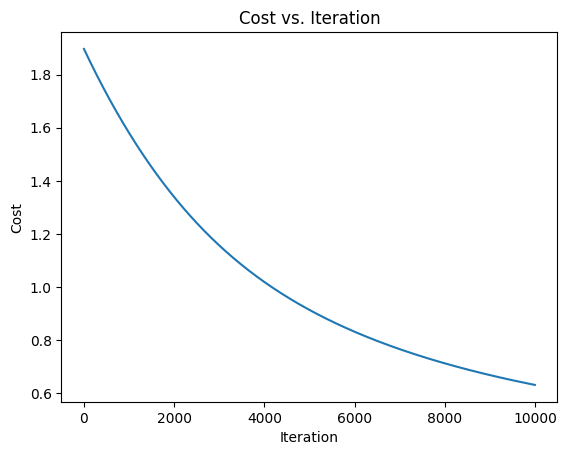

In [15]:
plt.plot(J_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost vs. Iteration")
plt.show()

In [16]:
# z=np.array([[52,0,3,136,196,0,2,169,0,0.1,2,0,3]])
# z=(z - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
# print(predict_tip(w,b,z))

In [17]:
p= predict_tip(w, b, X_train_scaled)
print('Train Accuracy: %f'%(np.mean(p == y) * 100))
print('cost', J_history[-1])

Train Accuracy: 74.456522
cost 0.6316702808298177


In [18]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=10000)
model.fit(X_train_scaled, y)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [19]:
print('Train Accuracy sklearn: %f'%(model.score(X_train_scaled, y) * 100))
print('cost',compute_cost(X_train_scaled, y, model.coef_[0], model.intercept_[0]))

Train Accuracy sklearn: 82.065217
cost 0.40582293999326147


In [20]:
from sklearn.linear_model import LogisticRegressionCV
model_cv = LogisticRegressionCV(max_iter=10000)
model_cv.fit(X_train_scaled, y)

,Cs,10
,fit_intercept,True
,cv,None
,dual,False
,penalty,'l2'
,scoring,None
,solver,'lbfgs'
,tol,0.0001
,max_iter,10000
,class_weight,None
,n_jobs,None


In [21]:
print(model_cv.score(X_train_scaled, y)*100)
print(compute_cost(X_train_scaled, y, model_cv.coef_[0], model_cv.intercept_[0]))

81.95652173913044
0.449084498363632


In [22]:
# lấy feature names(Ai)
num_features = num_cols
cat_features = preprocess.named_transformers_['cat'] \
    .named_steps['onehot'] \
    .get_feature_names_out(cat_cols)

feature_names = np.concatenate([num_features, cat_features])
importance = np.abs(model.coef_[0])

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

feature_importance_df.head(10)


,Feature,Importance
6,cp_atypical angina,0.815218
7,cp_non-anginal,0.604407
4,oldpeak,0.582850
5,sex_Male,0.464313
2,chol,0.459627
16,exang_TRUE,0.444327
13,thal_normal,0.295547
11,slope_flat,0.287519
0,age,0.267316
3,thalch,0.266529


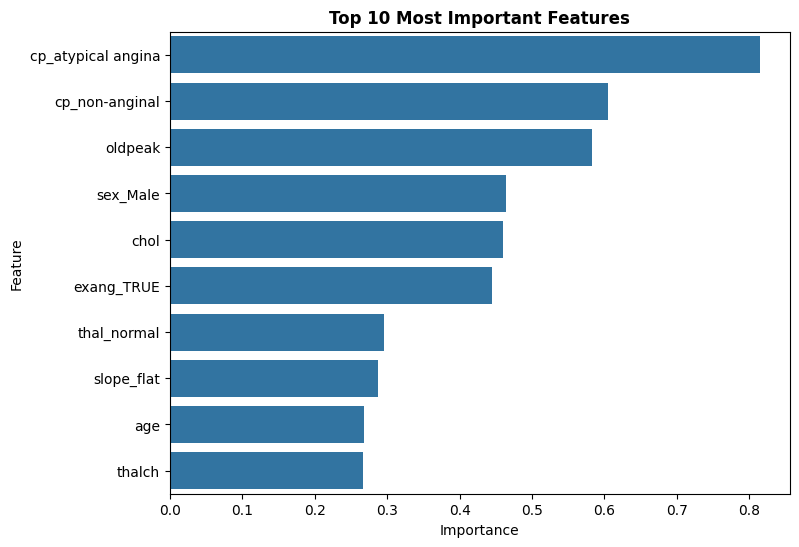

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
#(ai)
plt.figure(figsize=(8,6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df.head(10)
)
plt.title("Top 10 Most Important Features", fontweight='bold')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


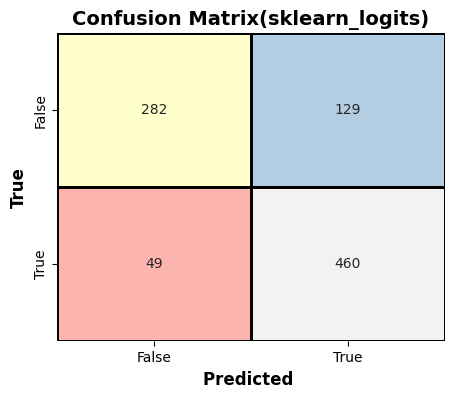

In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
y_pred=model.predict(X)
# confusion matrix
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(5, 4))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Pastel1",   
    cbar=False,
    linewidths=1,
    linecolor="black",
    xticklabels=["False", "True"],
    yticklabels=["False", "True"]
)

plt.xlabel("Predicted ", fontsize=12, fontweight="bold")
plt.ylabel("True", fontsize=12, fontweight="bold")
plt.title("Confusion Matrix(sklearn_logits)", fontsize=14, fontweight="bold")

plt.show()


In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # pyright: ignore[reportMissingImports]
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense # type: ignore
from tensorflow.keras.losses import BinaryCrossentropy # type: ignore
tf.config.run_functions_eagerly(True)
m,n = X.shape
model_tfuci = Sequential([
    Dense(64,name='layer1' ,activation='relu',
                          kernel_initializer='he_normal',
                          input_shape=(X.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.30),

    Dense(32, name='layer2', activation='relu',
                          kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.30),

    Dense(16, name='layer3', activation='relu'),
    tf.keras.layers.Dropout(0.20),

    Dense(1, name='output_layer',activation='linear')
])
#Dense - BatchNorm - ReLU - Dropout
#Dropout từ 0.45 đến 0.25 giảm dần theo từng layer(tắt ngẫu nhiên neuron khi TRAINING để tránh overfitting 45%, 35%, 25%)
model_tfuci.summary()


c:\Users\LOQ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer3 (Dense)                  │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,161 (16.25 KB)

 Trainable params: 3,969 (15.50 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2,
    stratify=y,
    random_state=42
)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0007,
    clipnorm=1.0   # chống exploding gradient
)

model_tfuci.compile(
    optimizer=optimizer,
    loss=BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
 
)
np.random.seed(1)
tf.random.set_seed(1)
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=60,
    restore_best_weights=True
)#để dừng sớm tránh overfit

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=60,
#     min_lr=1e-5
# )#giảm learing_rate khi đến epoch nhất định
model_tfuci.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    callbacks=[],
    verbose=1
)
logit=model_tfuci(X_test)
f_x=tf.nn.sigmoid(logit)
loss, acc = model_tfuci.evaluate(X_test, y_test, verbose=0)
print(f" Accuracy NN  {acc*100:.2f}%")


Epoch 1/200


c:\Users\LOQ\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.4579 - loss: 0.8547 - val_accuracy: 0.5380 - val_loss: 0.6432
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.5285 - loss: 0.7359 - val_accuracy: 0.5924 - val_loss: 0.6033
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.6019 - loss: 0.6538 - val_accuracy: 0.6359 - val_loss: 0.5731
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.6168 - loss: 0.6136 - val_accuracy: 0.6793 - val_loss: 0.5452
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.6630 - loss: 0.5786 - val_accuracy: 0.7120 - val_loss: 0.5201
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.6630 - loss: 0.5767 - val_accuracy: 0.7283 - val_loss: 0.5002
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.6943 - loss: 0.5500 - val_accuracy: 0.7391 - val_loss: 0.4845
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.7351 - loss: 0.5285 - val_accuracy: 0.7663 

In [39]:
w,b=model_tfuci.get_layer('output_layer').get_weights()
print('Weights:', w)    
print('Bias:', b)

Weights: [[-0.25107968]
 [ 0.16616899]
 [ 0.27459076]
 [ 0.31110215]
 [-0.20200062]
 [-0.2037875 ]
 [-0.4118923 ]
 [ 0.32821548]
 [ 0.21835808]
 [ 0.09615026]
 [-0.25749063]
 [-0.4195428 ]
 [ 0.48208243]
 [-0.1613615 ]
 [-0.14297672]
 [ 0.11213563]]
Bias: [0.0840008]


In [40]:

# X_train_scaled = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0) # normalization
z=np.array([67,'Male','asymptomatic',160,286,'FALSE','lv hypertrophy',108,'TRUE',1.5,'flat',3,'normal'])
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
z_df = pd.DataFrame([z], columns=columns)
z_processed = preprocess.transform(z_df)
logit = model_tfuci.predict(z_processed)
f_x=tf.nn.sigmoid(logit).numpy()
y_pred = (f_x >= 0.5).astype(int)
print(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[1]]


c:\Users\LOQ\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [41]:
from sklearn.metrics import classification_report
logit=model_tfuci.predict(X)
f_x=tf.nn.sigmoid(logit).numpy()
y_pred=(f_x>=0.5).astype(int)
print(classification_report(y,y_pred))

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       411
           1       0.85      0.90      0.88       509

    accuracy                           0.86       920
   macro avg       0.86      0.85      0.86       920
weighted avg       0.86      0.86      0.86       920



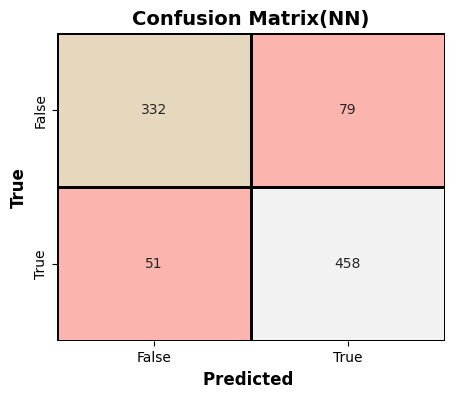

In [42]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# confusion matrix
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(5, 4))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Pastel1",   
    cbar=False,
    linewidths=1,
    linecolor="black",
    xticklabels=["False", "True"],
    yticklabels=["False", "True"]
)

plt.xlabel("Predicted ", fontsize=12, fontweight="bold")
plt.ylabel("True", fontsize=12, fontweight="bold")
plt.title("Confusion Matrix(NN)", fontsize=14, fontweight="bold")

plt.show()
